In [8]:
%load_ext autoreload

In [9]:
%autoreload 2
import os
import warnings
warnings.filterwarnings("ignore")
os.chdir(os.path.expanduser("/notebooks/segmentation"))

import numpy as np

import torch

from PIL import Image

from train_utils.utils import mIoU, Lion, Dice # pylint: disable=unused-import

from batchflow.batchflow import B, V, C, Pipeline
from batchflow.batchflow.models.torch.unet import UNet as Unet_bf
from batchflow.batchflow.models.torch import TorchModel
from batchflow.batchflow.research import Research, Domain, E, Alias
from batchflow.batchflow.research.utils import plot_research
from batchflow.batchflow.opensets import PascalSegmentation

In [11]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1, 2, 3"

In [12]:
BATCH_SIZE = 32
LR = 5*1e-4
NUM_CLASSES = 21
NUM_EPOCHS = 120
IMAGE_SHAPE = (256, 256)

In [13]:
ds = PascalSegmentation()
ds.split([0.7, 0.2, 0.1], shuffle=True)

In [14]:
domain = Domain(loss=[Alias({'name': 'ce', 'squeeze': True, 'ignore_index': 255, 'weight': 'adaptive'}, 'ce'), 
                      Alias(Dice, 'dice')],
               optimizer=[Alias({'name': Lion, 'lr': LR}, 'Lion'),
                          Alias({'name': 'Adam', 'lr': LR*10}, 'Adam')])

In [15]:
config = Unet_bf.default_config()
config['classes'] = NUM_CLASSES
config['inputs_shapes'] = (3, *IMAGE_SHAPE)
config['target_shapes'] = (1, *IMAGE_SHAPE)
config['head'] = {
    'channels': NUM_CLASSES,
    'layout': 'c',
    'output_type': 'tensor'
}
config['loss'] = C('loss')
config['optimizer'] = C('optimizer')
config['device'] = [torch.device('cuda:'+str(device)) for device in range(torch.cuda.device_count())]

In [16]:
preprocessing_pipeline = (
    Pipeline()
    .resize(
        size=IMAGE_SHAPE,
        resample=Image.Resampling.BILINEAR,
        src='images',
        dst='images'
    )
    .to_array(channels='first', dtype=np.float32, src='images', dst='images')
    .resize(
        size=IMAGE_SHAPE,
        resample=Image.Resampling.NEAREST,
        src='labels',
        dst='masks'
    )
    .to_array(channels='first', dtype=np.int64, src='masks', dst='masks')
)

train_model_pipeline = (
    Pipeline()
    .init_model('model', model_class=TorchModel, config=config)
    .train_model('model', inputs=B('images'), targets=B('masks'))
)

train_pipeline = (
    preprocessing_pipeline + \
    train_model_pipeline
).run_later(batch_size=BATCH_SIZE, shuffle=True, n_epochs=None)

train_pipeline = train_pipeline << ds.train

val_model_pipeline = (
    Pipeline()
    .import_model('model', C('import_from'))
    .init_variable('miou_val', [])
    .init_variable('miou', 0)
    
    .predict_model(
        'model',
        inputs=B('images'),
        outputs='predictions',
        save_to=B('predictions', mode='w'),
        transfer_from_device=False
    )
    .mIoU(preds=B('predictions'), mask=B('masks'), num_classes=NUM_CLASSES, save_to=V('miou_val', mode='w'))
)

val_pipeline = (
    preprocessing_pipeline + \
    val_model_pipeline
).run_later(batch_size=BATCH_SIZE, shuffle=True, n_epochs=1)

val_pipeline = val_pipeline << ds.validation

In [17]:
test_pipeline = (
    Pipeline()
    .init_variable('iou_test', [])
    .import_model('model', C('import_from'))
    .resize(size=IMAGE_SHAPE, resample=Image.Resampling.BILINEAR, src='images', dst='images')
    .to_array(channels='first', dtype=np.float32, src='images', dst='images')

    .resize(size=IMAGE_SHAPE, resample=Image.Resampling.NEAREST, src='labels', dst='masks')
    .to_array(channels='first', dtype=np.int64, src='masks', dst='masks')

    .predict_model('model', inputs=B.images,
                   outputs='predictions', save_to=B('predictions', mode='w'))
    .mIoU(preds=B('predictions'), mask=B('masks'), num_classes=NUM_CLASSES, save_to=V('iou_test', mode='a'))
    .run_later(batch_size=BATCH_SIZE, shuffle=False, n_epochs=1, drop_last=False)
)

test_pipeline = test_pipeline << ds.test

In [18]:
research = (Research(domain=domain)
            .add_pipeline(name='train_pipeline', root=train_pipeline)
            .add_pipeline(
                name='val_pipeline',
                root=val_pipeline, 
                variables='miou_val',
                when=5,
                import_from=E('train_pipeline'),
                run=True
            )
            .add_pipeline(
                name='test_pipeline',
                root=test_pipeline,
                variables='iou_test',
                when='last',
                import_from=E('train_pipeline'),
                run=True
            )
           )
research.run(n_iters=6000, bar=True, dump_results=False, workers=8)

In [24]:
loss_optimizer_results = research.results.to_df(concat_config=True, drop_columns=True)
print(loss_optimizer_results)

,id,config,iteration,miou_val,iou_test
0,a5fe499223853495,loss_dice-optimizer_Adam,4,3.1022223e-14,NaN
1,a5fe499223853495,loss_dice-optimizer_Adam,9,7.351447e-15,NaN
2,a5fe499223853495,loss_dice-optimizer_Adam,14,3.4507153e-14,NaN
3,a5fe499223853495,loss_dice-optimizer_Adam,19,2.3816815e-13,NaN
4,a5fe499223853495,loss_dice-optimizer_Adam,24,0.007850681,NaN
...,...,...,...,...,...
4795,851e539240207686,loss_ce-optimizer_Adam,5979,0.038685888,NaN
4796,851e539240207686,loss_ce-optimizer_Adam,5984,0.03874142,NaN
4797,851e539240207686,loss_ce-optimizer_Adam,5989,0.023733638,NaN
4798,851e539240207686,loss_ce-optimizer_Adam,5994,0.025095511,NaN


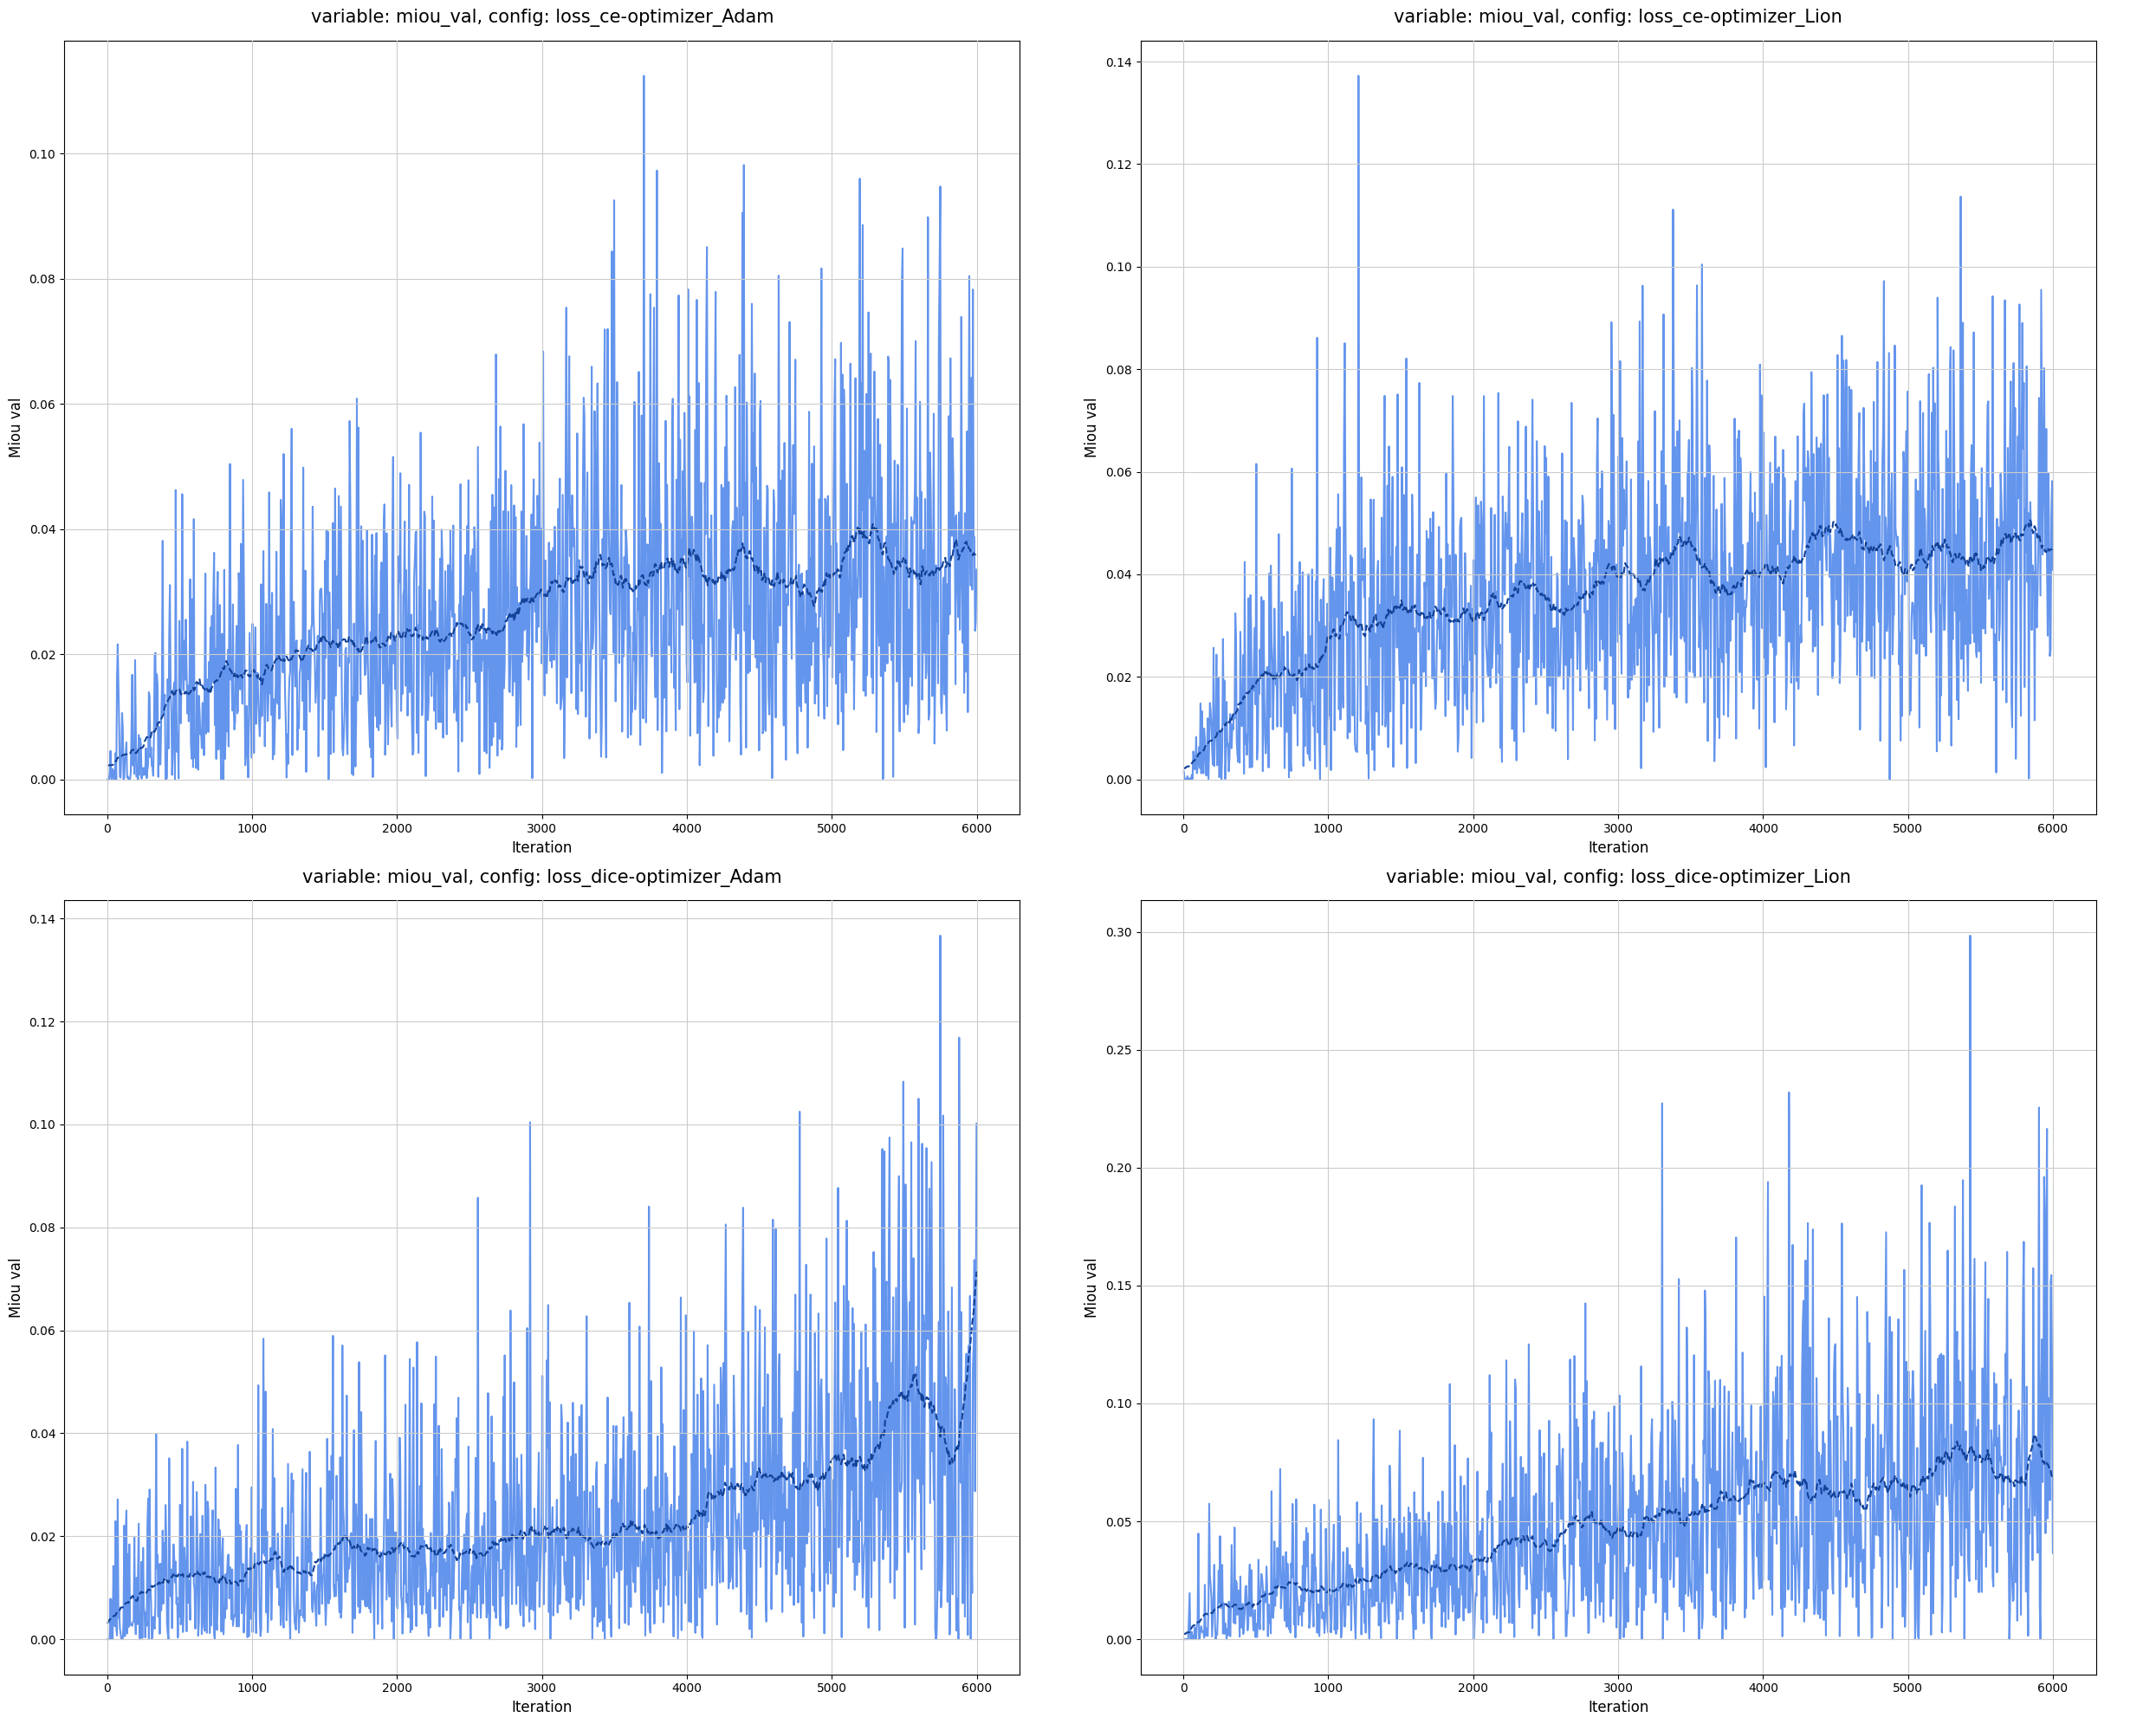

In [27]:
plot_research(
    df=loss_optimizer_results,
    subplots=['config'],
    variables=['miou_val'],
    figsize=(25, 20),
    title_size=15,
    legend_size=7,
    nrows=2,
    ncols=2,
    window=50
)

In [26]:
loss_optimizer_results['iou_test'] = loss_optimizer_results['iou_test'].apply(np.mean)
print(loss_optimizer_results[~loss_optimizer_results['iou_test'].isnull()])

,id,config,iteration,miou_val,iou_test
1199,a5fe499223853495,loss_dice-optimizer_Adam,5999,0.10016576,0.115672
2399,11e0ecc768216636,loss_dice-optimizer_Lion,5999,0.036596052,0.147277
3599,39c1ad8907123349,loss_ce-optimizer_Lion,5999,0.040858254,0.123854
4799,851e539240207686,loss_ce-optimizer_Adam,5999,0.033509463,0.084190


In [24]:
from nbtools import pylint_notebook
pylint_notebook()

Your code has been rated at 10.00/10 (previous run: 10.00/10, +0.00)
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
